#### YAS PLS spatial nulls


- Author: A.Zarkali
- Date last updated: 10/9/202
- Aim: Perform PLS on empirical and spatial null models on YAS HD cohort

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import shapiro
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from pandas.api.types import is_numeric_dtype
import numpy as np
from pathlib import Path
from scipy.io import loadmat
from pingouin import partial_corr
# Enable inline plotting
%matplotlib inline

C:\Users\Angelika\Anaconda3\envs\Graph\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\Angelika\Anaconda3\envs\Graph\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [50]:
# Load data
clinical_data = pd.read_excel(r"C:/Users/Angelika/Dropbox/PhD/EXPERIMENTS/OTHER/YAS_genes_09.04.21_with_mp/Demos_for_PMcC_YAS_nfl_all.xlsx")
clinical_data.head(0)

#connectomes = loadmat(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\resultsROI_Condition001_100.mat")

C:\Users\Angelika\Anaconda3\envs\Graph\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  


1

In [60]:
connectomes["Z"][:,:114,33].shape

(114, 114)

In [51]:
# Sum connectivity values to create a 114 * 1 vector

## Dataframe to hold all participant connectomes
combined_connectivity = pd.DataFrame(np.zeros((114, len(clinical_data))))

## Data folder for connectomes
for i in range(len(clinical_data)):
    # get participant id 
    participant_name = clinical_data["ID"].iloc[i]
    # get order
    order = clinical_data["order"].iloc[i] - 1 # -1 as matlab has 1 rather than 0 indexing
    # get connectome
    matrix = pd.DataFrame(data=connectomes["Z"][:,1:,order])
    # sum connectivity 
    sum_participant = matrix.sum(axis=1)
    # add to output dataframe
    combined_connectivity[i] = sum_participant
# add participant ids and save
combined_connectivity.columns = clinical_data["ID"].values
combined_connectivity.to_csv("CombinedConnectivity_114.csv")

In [11]:
annot = loadmat(r"C:/Users/Angelika/Dropbox/PhD/EXPERIMENTS/OTHER/YAS_genes_09.04.21_with_mp/nflmatcorr_114.mat") ## load the matfile
mat = annot["nflmatcorr_114"]

In [64]:
### Calculate spearman correlation coefficient between combined connectivity and NFL

combined_connectivity = pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\SpherePermutations\CombinedConnectivity_114.csv")
df1 = clinical_data # clinical data
df2 = combined_connectivity.transpose() # connectivity data
## change labels as mixedlm does not accept int as column names
stringROIs = [str(x) for x in df2.columns]
stringROIsNew = ["Node_" + item for item in stringROIs]
df2.columns = stringROIsNew
df2["ID"] = df2.index # add participant ID
data = pd.merge(df1, df2, on="ID") # merge

# Declare empty lists
pvalues = []
coefficients = []
CI = []
        
for i in range(114):
        Y = "Node_" + str(i)
        res = partial_corr(data=data, x='NFL', y=Y, covar=['Age', 'Sex'])
        ### Append results to empty lists
        pvalues.append(res["p-val"].iloc[0])
        coefficients.append(res.r.iloc[0])
        CI.append(res["CI95%"].iloc[0])
# FDR correct the p-values
FDR = sm.stats.multipletests(pvalues, is_sorted=False, alpha=0.05, method="fdr_bh", returnsorted=False)
# Merge to Dataframe and export as csv
outdata = pd.DataFrame(data=np.zeros((114,0))) ### for tracts
outdata["ROIs"] = stringROIsNew[:114] ### name of ROIs
outdata["Coef"] = coefficients
outdata["CI"] = CI
outdata["pValues"] = pvalues
outdata["FDR"] = FDR[1]
outdata.to_csv("SumConnectivity_PartialCor_114_Functional.csv")

In [68]:
# ### Loop through all ROIs to calculate interaction for null models
# ## Declare the datase
combined_connectivity = pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\SpherePermutations\CombinedConnectivity_114.csv")

df1 = clinical_data # clinical data
df2 = combined_connectivity.transpose() # connectivity data
## change labels as mixedlm does not accept int as column names
stringROIs = [str(x) for x in df2.columns]
stringROIsNew = ["Node_" + item for item in stringROIs]
df2.columns = stringROIsNew
df2["ID"] = df2.index # add participant ID
data = pd.merge(df1, df2, on="ID") # merge

# Declare covariates 
### note that D2 is the preHD diagnosis
vc = {"Age": "Age", "Sex": "0 + C(Sex)"} 
# Declare empty lists
pvalues = []
coefficients = []
lowerCI = []
upperCI = []
        
# ### Loop through all ROIS 
for i in range(114): 
        formula = str("Node_" + str(i) + "~ NFL + C(D2) + NFL*C(D2)")
        md = sm.MixedLM.from_formula(formula, data, re_formula="1", vc_formula=vc, groups=data["D2"])
        mdf = md.fit(method=["lbfgs"])
        ### Select the values I want from the model
        p = mdf.pvalues["NFL:C(D2)[T.1]"]
        coef = (mdf.conf_int().loc["NFL:C(D2)[T.1]"]).mean()
        lower = (mdf.conf_int().loc["NFL:C(D2)[T.1]"])[0]
        upper = (mdf.conf_int().loc["NFL:C(D2)[T.1]"])[1]
        ### Append them to the empty lists
        pvalues.append(p)
        coefficients.append(coef)
        lowerCI.append(lower)
        upperCI.append(upper)
# FDR correct the p-values
FDR = sm.stats.multipletests(pvalues, is_sorted=False, alpha=0.05, method="fdr_bh", returnsorted=False)

# Merge to Dataframe and export as csv
outdata = pd.DataFrame(data=np.zeros((114,0))) ### for tracts
outdata["ROIs"] = stringROIsNew[:114] ### name of ROIs
outdata["Coef"] = coefficients
outdata["lowerCI"] = lowerCI
outdata["upperCI"] = upperCI
outdata["pValues"] = pvalues
outdata["FDR"] = FDR[1]
outdata.to_csv("NFLconnectivity_Interaction_114_Functional.csv")

In [57]:
# formula = str("Node_" + str(107) + "~ NFL + C(D2) + NFL*C(D2)")
# vc = {"Age": "Age"} 
# md = sm.MixedLM.from_formula(formula, data, re_formula="1", vc_formula=vc, groups=data["D2"])
# mdf = md.fit(method=["lbfgs"])
# ### Select the values I want from the model
# print(mdf.summary())

In [113]:
pvalues = np.loadtxt("list.txt")
FDR = sm.stats.multipletests(pvalues, is_sorted=False, alpha=0.05, method="fdr_bh", returnsorted=False)
np.savetxt("outlist.txt", FDR[1])

# PLS

### Perform PLS on empirical data

In [82]:
### Define matrices for Low Vis Performers patients
## define X matrix
### load genetic expression data
gene_data= pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\S114_expression_300720.csv")
gene_data = gene_data.fillna(0)
gene_data = gene_data.drop(columns="label")
X = gene_data.values
# define y matrix 
## load the NFL-group interaction dataframe
nfl_data = pd.read_csv(r"C:/Users/Angelika/Dropbox/PhD/EXPERIMENTS/OTHER/YAS_genes_09.04.21_with_mp/SpherePermutations/PLS/SumCon_GroupInteraction/NFLconnectivity_Interaction_114_Functional.csv", index_col=0) # single vector
# nfl_data = pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\table_rho_gt_metrics_model_groupinteraction_with_catvars.csv")  # 4 * vectors

nfl_data = pd.DataFrame(nfl_data["Coef"], index=[i for i in range(114)]) # single vector
nfl_data = nfl_data.fillna(0)
# nfl_data = pd.DataFrame(nfl_data, index=[i for i in range(114)]) # 4 * vectors
y = nfl_data.values

# nfl_data  = pd.DataFrame(mat, index=[i for i in range(114)]) ## for matlab correlation matrix
# nfl_data  = nfl_data .fillna(0)
# y  = nfl_data .values

In [83]:
import hoggorm as ho
import hoggormplot as hop

# Get the variable or columns names
X_varNames = ["GeneExpression"]
y_varNames = gene_data.columns
# Get the object or row names
X_objNames = list(nfl_data.index)
y_objNames = list(nfl_data.index)
# Apply PLS to data
model = ho.nipalsPLS1(arrX=X, Xstand=False, 
                      vecy=y,
                      cvType=["loo"], 
                      numComp=10)

loo


In [26]:
### PLS2 for multivariate data
import hoggorm as ho
import hoggormplot as hop

# Get the variable or columns names
X_varNames = ["GeneExpression"]
y_varNames = gene_data.columns
# Get the object or row names
X_objNames = list(nfl_data.index)
y_objNames = list(nfl_data.index)
# Apply PLS to data
model = ho.nipalsPLS2(arrX=X, Xstand=False, 
                      arrY=y, Ystand=False,
                      cvType=["loo"], 
                      numComp=10)

loo


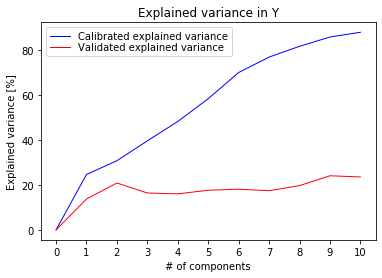

In [84]:
# Plot variance
hop.plot(model, comp=[1,4], plots=[6], which=["Y"],
         objNames=X_objNames, 
         XvarNames=X_varNames)

In [86]:
# Get calibrated explained variance of each component in Y
Y_calExplVar = model.Y_calExplVar()

# Get calibrated explained variance in Y and store in pandas dataframe with row and column names
Y_calExplVar_df = pd.DataFrame(model.Y_calExplVar())
Y_calExplVar_df.columns = ['calibrated explained variance in Y']
Y_calExplVar_df.index = ['Comp {0}'.format(x+1) for x in range(model.Y_loadings().shape[1])]
Y_calExplVar_df

,calibrated explained variance in Y
Comp 1,24.652336
Comp 2,6.117580
Comp 3,8.857874
Comp 4,8.609610
Comp 5,10.125618
Comp 6,11.647503
Comp 7,6.867000
Comp 8,4.788577
Comp 9,4.130423
Comp 10,2.125497


In [87]:
# Get calibrated explained variance of each component in X
X_calExplVar = model.X_calExplVar()

# Get calibrated explained variance in X and store in pandas dataframe with row and column names
X_calExplVar_df = pd.DataFrame(model.X_calExplVar())
X_calExplVar_df.columns = ['calibrated explained variance in X']
X_calExplVar_df.index = ['Comp {0}'.format(x+1) for x in range(model.X_loadings().shape[1])]
X_calExplVar_df

,calibrated explained variance in X
Comp 1,12.692848
Comp 2,17.448825
Comp 3,19.066169
Comp 4,18.022956
Comp 5,3.457340
Comp 6,1.729962
Comp 7,2.728187
Comp 8,2.517905
Comp 9,1.570499
Comp 10,2.330673


In [89]:
# Get X scores and store in numpy array (cortical regions)
X_scores = model.X_scores()

# Get scores and store in pandas dataframe with row and column names
X_scores_df = pd.DataFrame(model.X_scores())
X_scores_df.index = X_objNames
X_scores_df.columns = ['Comp {0}'.format(x+1) for x in range(model.X_scores().shape[1])]
X_scores_df.to_csv("PLS_RegionsScore_SumCon_NFLInteraction.csv")

In [90]:
# Get X loadings and store in numpy array
X_loadings = model.X_loadings()

# Get X loadings and store in pandas dataframe with row and column names
X_loadings_df = pd.DataFrame(model.X_loadings())
X_loadings_df.columns = ['Comp {0}'.format(x+1) for x in range(model.X_loadings().shape[1])]
X_loadings_df.to_csv("PLS_Loadings_SumCon_NFLInteraction.csv")

### Perform PLS on spatially correlated nulls

In [92]:
## Step 1

# Perform PLS on spatially correlated maps of genes
import hoggorm as ho
import hoggormplot as hop

### Number of ROIs and permutations
n_roi = 114
n_perm = 1000

# Load permutations file
permutation = pd.read_csv(r"Permutations/permutations_Schaffer114.txt", header = None, delimiter=" ")

### Define matrices 
# X matrix
# gene_data= pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\S114_expression_300720.csv")
# gene_data = gene_data.fillna(0)
# gene_data = gene_data.drop(columns="label")
# X = gene_data.values
# define y matrix
# nfl_data = pd.read_csv(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\OTHER\YAS_genes_09.04.21_with_mp\SpherePermutations\NFLconnectivity_Interaction_114.csv", index_col=0)
# nfl_data = nfl_data.fillna(0)
# nfl_data = pd.DataFrame(nfl_data["Coef"], index=[i for i in range(114)])
# y = nfl_data.values
# Get the variable or columns names
# X_varNames = ["GeneExpression"]
# y_varNames = gene_data.columns
# # Get the object or row names
# X_objNames = list(nfl_data.index)
# y_objNames = list(nfl_data.index)

#Declare empty dataframes
permutWeights = pd.DataFrame(data=np.zeros(len(y_varNames)))
permutWeights.columns=["Empty"]
permutVariance = pd.DataFrame(data=np.zeros(2))
permutVariance.columns=["Empty"]

for i in range(n_perm):
    rotated_index = permutation[i] 
    perm = np.empty((n_roi,1)) # for single vector
#     perm = np.empty((n_roi,n_roi)) # for multiple vectors
    for j in range(n_roi):
        perm[j] = y[(rotated_index[j] - 1)] # -1 as starting from 0
    #Apply PLS to data
#     model = ho.nipalsPLS1(arrX=X, Xstand=False, vecy=perm, cvType=["loo"], numComp=2) # for single vector
    model = ho.nipalsPLS2(arrX=X, Xstand=False, arrY=y, Ystand=False, cvType=["loo"], numComp=2) # for multiple vectors
    X_loadings = model.X_loadings()
    permutWeights[str("Run" + str(i))] = X_loadings[:,1] # select the second PLS component weight
    Y_calExplVar = model.Y_calExplVar()
    permutVariance[str("Run" + str(i))] = Y_calExplVar
permutVariance.to_csv("SpatialPermutVariance_114_SumCon_NFLInteraction.csv")
permutWeights.to_csv("SpatialPermutLoadings_114_SumCon_NFLInteraction.csv")

In [94]:
# ### STEP 2
# # Assess permutation testing results
# from scipy.stats import percentileofscore

# #Read the database
# dfAll = pd.read_csv(r"C:/Users/Angelika/Dropbox/PhD/EXPERIMENTS/OTHER/YAS_genes_09.04.21_with_mp/SpherePermutations/PLS/SumCon_GroupInteraction/SpatialPermutLoadings_114_SumCon_NFLInteraction.csv")
# dfAll["Gene_Names"] = y_varNames
# # # Select subset with random permutations only
# dfPerm = dfAll
# dfPerm = dfPerm.drop(columns=["Comp 1" , "Comp 2"])
# # # Calculate Z score of the permutation database

# dfPerm["Mean"] = dfPerm.mean(axis=1)
# dfPerm["STD"] = dfPerm.std(axis=1)
# dfPerm["SE"] = dfPerm.sem(axis=1)
# # # Create new dataframe with mean and std of the random permutations and the actual PLS results
# columnsPerm = ["Mean", "STD", "SE"]
# dfPermResults = dfPerm[columnsPerm]
# dfPermResults["PLS_Results"] = dfAll["Comp 1"]
# dfPermResults["Gene_Names"] = dfAll.Gene_Names
# dfPermResults["Percentile"] = dfPermResults["PLS_Results"].apply(lambda x: percentileofscore(dfPermResults['PLS_Results'], x, kind='weak'))
# dfPermResults["pValue"] = np.zeros(len(dfAll["Gene_Names"]))
# dfPermResults["Z_score"] = np.zeros(len(dfAll["Gene_Names"]))
# for i in range(len(dfAll["Gene_Names"])):
#     if dfPermResults.Percentile.iloc[i] <50:
#         dfPermResults.pValue.iloc[i] = dfPermResults.Percentile.iloc[i] / 100
#         dfPermResults.Z_score.iloc[i] = dfPermResults.PLS_Results.iloc[i] / dfPerm.SE.iloc[i]
#     else:
#         dfPermResults.pValue.iloc[i] = (100 - dfPermResults.Percentile.iloc[i]) /100
#         dfPermResults.Z_score.iloc[i] = dfPermResults.PLS_Results.iloc[i] / dfPerm.SE.iloc[i]

In [172]:
### STEP 3

# FIQT correct
from sklearn.preprocessing import QuantileTransformer
def fiqt(z):
    p_min = 1.00E-300
    pvals = stats.norm.sf(abs(z))*2 # calculate p value from z score
    for i in range(len(pvals)):
        if pvals[i] < p_min:
            pvals[i] = p_min
    pvals_corrected = sm.stats.multipletests(pvals, is_sorted=False, alpha=0.05, method="fdr_bh", returnsorted=False)
    #fiqt_corrected = quantile_transform(pvals_corrected[1].reshape(-1,1))
    return pvals_corrected[1]

In [95]:
# dfPermResults["FDR"] = fiqt(dfPermResults.Z_score)
dfPermResults.to_csv("PLSresults_Comp1_114_Spatial_SumConnectivity_GroupInteraction.csv")

In [96]:
# Select results that are statistically significant
dfPermResults = dfPermResults[dfPermResults.pValue <= 0.05]
dfGenepos = dfPermResults[dfPermResults.PLS_Results > 0]
dfGeneneg = dfPermResults[dfPermResults.PLS_Results < 0]
dfGeneneg.to_csv("PLS_NFLInteraction_114_neg_SumConnectivity_GroupInteraction.csv")
dfGenepos.to_csv("PLS_NFLInteraction_114_pos_SumConnectivity_GroupInteraction.csv")